# 0. Explanation of the data

The data contains the results of the AB test. The test was conducted on various users. 

Important: users could use different browsers (therefore, only the combination of userID and browser is considered unique)

### Data description

+ userID: Unique user ID
+ browser: Browser, which uses userID
+ slot: User status (exp - saw the changes to the web page, control - didn't see the web page change)
+ n_clicks: The number of clicks that the user made for n_queris page requests
+ n_queries: The number of page requests, which were made by the user userID, using the browser "browser"
+ n_nonclk_queries: The number of page requests, in which they have not made a single click

# 1. Downloading and exploring data

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import chisquare
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(r'data\ab_browser_test.csv')

In [4]:
data

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
...,...,...,...,...,...,...
566129,603133,Browser #14,control,1,2,1
566130,603134,Browser #2,exp,4,2,0
566131,603135,Browser #4,control,0,1,1
566132,603136,Browser #4,control,2,3,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [6]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


The data has no gaps, so no preprocessing is required.

In [7]:
control = data[data['slot'] == 'control']
exp = data[data['slot'] == 'exp']

In [8]:
control.shape[1] - exp.shape[0]

-281574

The number of users in contorol and exp does not differ significantly compared to the size of the data.

Let's look how much more user clicks are in the "exp" group compared to "control" as a percentage of the number of clicks in the control group

In [9]:
control_clicks = sum(control['n_clicks'])
exp_clicks = sum(exp['n_clicks'])
np.round(((exp_clicks - control_clicks)/control_clicks)*100, 3)

1.614

# 2. Checking for data normality

Since I plan to use the Student's t-test in the future, I need to check the data.

1. The mean in the sample is distributed normally
1. The variance must be distributed over chi-2 with n-1 degrees of freedom (n is the length of the data)

In [10]:
# generating bootstrap samples
def get_bootstrap_samples(data, n_samples):
    data_len = len(data)
    ind = np.random.randint(0, data_len, (n_samples, data_len))
    return data[ind]

In [11]:
# calculates the quantile of the alpha level, so we get the boundaries of the confidence interval
def stat_intervals(stat, alpha = 0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
data_control_clicks = data[data['slot'] == 'control']['n_clicks'].values
data_exp_clicks = data[data['slot'] == 'exp']['n_clicks'].values

## 2.1 Control

In [13]:
np.random.seed(0)
n_boot_samples = 500

data_boots_control = get_bootstrap_samples(data_control_clicks, n_boot_samples)

In [14]:
data_boots_control.shape

(500, 284554)

In [15]:
limean, listd = [], []
for i in data_boots_control:
    limean.append(np.mean(i))
    listd.append(scipy.std(i))

0.9979748364604207


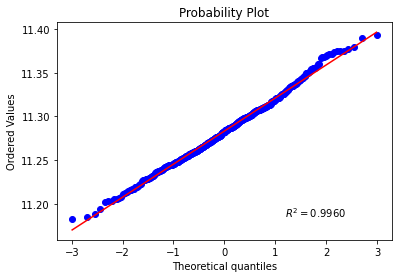

In [16]:
_, r_mean = scipy.stats.probplot(limean, plot=plt, rvalue=True);
print(r_mean[2])

0.9986400904214092


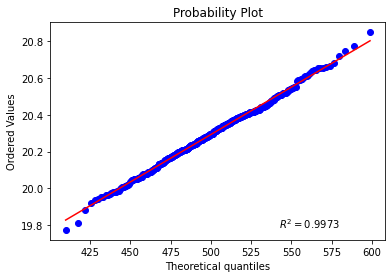

In [17]:
_, r_mean_chi = scipy.stats.probplot(listd,sparams=(len(listd)-1), dist='chi2', plot=plt, rvalue=True);
print(r_mean_chi[2])

In [18]:
print("Mean R^2: %f" % r_mean[2])
print("Chi square R^2: %f" % r_mean_chi[2])

Mean R^2: 0.997975
Chi square R^2: 0.998640


## 2.2 Exp

In [19]:
np.random.seed(0)
n_boot_samples = 500

data_boots_exp = get_bootstrap_samples(data_exp_clicks, n_boot_samples) 

In [20]:
limean, listd = [], []
for i in data_boots_exp:
    limean.append(np.mean(i))
    listd.append(scipy.std(i))

0.9986831164372165


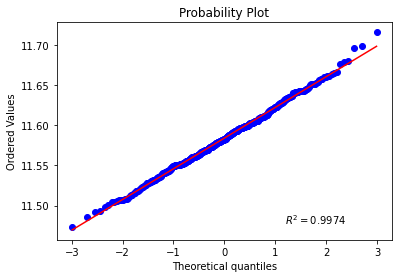

In [21]:
_, r_mean = scipy.stats.probplot(limean, plot=plt, rvalue=True);
print(r_mean[2])

0.9981445027951426


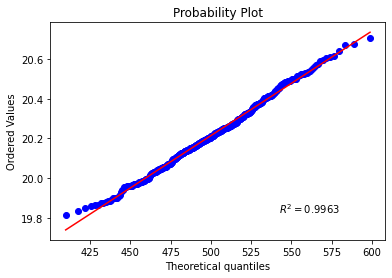

In [22]:
_, r_std = scipy.stats.probplot(listd, sparams=(len(listd)-1), dist='chi2', plot=plt, rvalue=True)
print(r_std[2])

In [23]:
print("Mean R^2: %f" % r_mean[2])
print("Chi square R^2: %f" % r_mean_chi[2])

Mean R^2: 0.998683
Chi square R^2: 0.998640


Both exp and control satisfy the requirements. So can use this data for the Student's t-test.

# 3. Comparison of "control" and "exp" samples


**Let's do it in two different ways**

## 3.1 Using the parametric criterion and bootstrap

Let's make a 95% confidence interval for the mean and median, number of clicks in each of the 2 groups.

### 3.1.1 Mean

In [24]:
print('mean control',np.round(_tconfint_generic(control['n_clicks'].mean(),np.sqrt(control['n_clicks'].std()/control.shape[0]),control.shape[0]-1, alpha=0.05,alternative='two-sided'),2))

mean control [11.26 11.3 ]


In [25]:
print('mean exp',np.round(_tconfint_generic(exp['n_clicks'].mean(),np.sqrt(exp['n_clicks'].std()/exp.shape[0]),exp.shape[0]-1, alpha=0.05,alternative='two-sided'),2))

mean exp [11.57 11.6 ]


In [26]:
cm = CompareMeans(DescrStatsW(exp['n_clicks']), DescrStatsW(control['n_clicks']))
print('mean diff',np.round(cm.tconfint_diff(usevar='unequal'),2))

mean diff [0.2  0.41]


### 3.1.2 Median

In [27]:
np.random.seed(0)
samples_count = 500 # number of samples generated

control_medians_selection = np.array(list(map(lambda temps: np.median(temps), get_bootstrap_samples(control['n_clicks'].values, samples_count))))
exp_medians_selection = np.array(list(map(lambda temps: np.median(temps), get_bootstrap_samples(exp['n_clicks'].values, samples_count))))
tem_deff = exp_medians_selection - control_medians_selection

In [28]:
print('median control', np.round(stat_intervals(control_medians_selection, 0.05),4))

median control [4. 4.]


In [29]:
print('median exp', np.round(stat_intervals(exp_medians_selection, 0.05),4))

median exp [5. 5.]


In [30]:
print('median diff ', np.round(stat_intervals(tem_deff, 0.05),4))

median diff  [1. 1.]


1. Mean:
    + In the case of "exp", users clicked more.
1. Median:
    + In the case of "exp", users clicked more.
    
So we can suggest that the samples are different. Let's check it by another method

## 3.2 Mann-Whitney test

Can use it, since the selections are not related.

In [31]:
control_user_agg = control[['userID', 'n_clicks']].groupby('userID').agg('sum')
control_user_agg

,n_clicks
userID,
6,12
8,4
10,22
15,2
23,3
...,...
603128,5
603132,1
603133,1


In [32]:
exp_user_agg = exp[['userID', 'n_clicks']].groupby('userID').agg('sum')
exp_user_agg

,n_clicks
userID,
1,23
3,3
5,29
7,54
9,6
...,...
603129,0
603130,0
603131,4


In [33]:
stats.mannwhitneyu(control_user_agg['n_clicks'].values, exp_user_agg['n_clicks'].values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=8.694294377520879e-75)

+ **pvalue < 0.05. Therefore, we can reject the hypothesis H0 about the sameness of samples. (The important point is that these criteria check statistical significance)**

# 4. Comparison by browsers

For each browser, we will find a difference in the control and experimental groups

We use the Mann-Whitney criterion with the Holm-Bonferonni correction for multiple verification.

In [34]:
# return p-value (without correction for multiple verification)
# creating this function to simplify calculations
def p_value_browser(data1, data2, browser):
    stat = stats.mannwhitneyu(data1[data1['browser'] == browser]['n_clicks'].values, data2[data2['browser'] == browser]['n_clicks'].values, alternative='two-sided')
    return stat.pvalue

In [35]:
# what browsers are in the data
browsers = set(data['browser'].values)
browsers

{'Browser #14',
 'Browser #17',
 'Browser #2',
 'Browser #20',
 'Browser #22',
 'Browser #4'}

In [36]:
control_browser = control[['browser', 'n_clicks']]
exp_browser = exp[['browser', 'n_clicks']]

In [37]:
control_browser.head()

,browser,n_clicks
3,Browser #4,12
5,Browser #4,4
7,Browser #4,22
9,Browser #14,2
13,Browser #4,3


In [38]:
exp_browser.head()

,browser,n_clicks
0,Browser #2,23
1,Browser #4,3
2,Browser #4,29
4,Browser #4,54
6,Browser #4,6


In [39]:
p_values_mann = [p_value_browser(control_browser, exp_browser, browser) for browser in browsers]

In [40]:
p_values_mann

[0.8152123531690997,
 0.9073331277747075,
 0.5148110304420064,
 0.0,
 0.0544877208394482,
 0.07480120286021603]

In [41]:
# apply correction for multiple verification
reject, p_corrected, a1, a2 = multipletests(p_values_mann, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [42]:
# False - accept H0 (about the sameness of samples), True - reject H0
reject

array([False, False, False,  True, False, False])

In [43]:
# p-values after correction
p_corrected

array([1.        , 1.        , 1.        , 0.        , 0.2724386 ,
       0.29920481])

In [44]:
for p, r, b in zip(p_corrected, reject, browsers):
    print(b,":",np.round(p,2),r)

Browser #4 : 1.0 False
Browser #20 : 1.0 False
Browser #22 : 1.0 False
Browser #14 : 0.0 True
Browser #2 : 0.27 False
Browser #17 : 0.3 False


In [45]:
# number of not significant changes
len(reject) - sum(reject)

5

**As can see that there are significant differences only in browser#14**

Let's calculate in each of the browsers the proportion of requests in which the user has not clicked once. And compare it with our result.

In [46]:
for browser in browsers: 
    n_nonclk_queries_control = control[control['browser'] == browser]['n_nonclk_queries'].values.sum()
    n_queries_control = control[control['browser'] == browser]['n_queries'].values.sum()

    n_nonclk_queries_exp = exp[exp['browser'] == browser]['n_nonclk_queries'].values.sum()
    n_queries_exp = exp[exp['browser'] == browser]['n_queries'].values.sum()
    
    per_non_clicks_control = n_nonclk_queries_control/n_queries_control * 100
    per_non_clicks_exp = n_nonclk_queries_exp/n_queries_exp * 100
    print(browser)
    print('control : ', per_non_clicks_control)
    print('exp :', per_non_clicks_exp)
    print('diff :', per_non_clicks_control - per_non_clicks_exp)
    print('--------------------------------------------------')

Browser #4
control :  46.97092963514274
exp : 45.14294190358467
diff : 1.8279877315580677
--------------------------------------------------
Browser #20
control :  40.540484743383296
exp : 38.97737648371716
diff : 1.5631082596661372
--------------------------------------------------
Browser #22
control :  40.593976593513354
exp : 39.85394721969546
diff : 0.7400293738178902
--------------------------------------------------
Browser #14
control :  57.59041136008114
exp : 43.755617361273295
diff : 13.834793998807847
--------------------------------------------------
Browser #2
control :  45.96274717919465
exp : 44.982746948554706
diff : 0.9800002306399449
--------------------------------------------------
Browser #17
control :  36.29936674628208
exp : 36.93741284866483
diff : -0.6380461023827451
--------------------------------------------------


***We can also see that the results are quite different only in browser#14***